# 1. Problemin müəyyənləşdirilməsi (Problem Definition)
Layihənin məqsədi:\
Bu layihənin əsas məqsədi müxtəlif avtomobil brendlərinə aid loqoları şəkil əsasında avtomatik olaraq tanıya biləcək bir təsnifat modeli (classification model) qurmaqdır. Modelə bir avtomobil loqosu şəkli verildikdə, o bu loqonun hansı brendə aid olduğunu müəyyən etməlidir.

Problem növü:\
Bu problem təsnifat (classification) problemidir, çünki giriş olaraq bir şəkil verilir və çıxış olaraq model həmin şəkili 8 avtomobil brendindən birinə aid etməlidir.

# 2. Məlumatların toplanması və tanınması (Data Collection & Understanding)


In [12]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import seaborn as sns
import os
from keras.applications import VGG19
from os import listdir, makedirs
from os.path import join, exists, expanduser
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from numpy import newaxis
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense,Activation,Dropout,Flatten,BatchNormalization
from glob import glob
from keras.applications import VGG19
from skimage.feature import local_binary_pattern
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.regularizers import l2
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image

Bu layihədə istifadə olunan məlumatlar Kaggle platformasından əldə edilib:

Datasetin linki:\
https://www.kaggle.com/code/volkandl/car-brand-classification/input

Bu dataset avtomobil brendlərinin loqolarını ehtiva edən şəkillərdən ibarətdir.Fayl zip formatındadır.
faylı yükləyirik və unzip edirik

In [3]:
import zipfile

zip_path = "/content/archive.zip"  # Faylın real adını buraya yaz
extract_to = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


Şəkillər iki hissəyə bölünüb:\
Train/ – öyrədilmə üçün şəkillər

Test/ – test üçün şəkillər

In [5]:
import random
# Dataset qovluqları
base_dir = "/content/Car_Brand_Logos"
train_dir = os.path.join(base_dir, "Train")
test_dir  = os.path.join(base_dir, "Test")

**Brendlərin siyahısı və şəkil sayı:**

In [8]:
brands = os.listdir(train_dir)
train_counts = {brand: len(glob(os.path.join(train_dir, brand, "*.jpg")))
                for brand in brands}
test_counts  = {brand: len(glob(os.path.join(test_dir, brand, "*.jpg")))
                for brand in brands}

print("Train dəstində şəkil sayı per brend:", train_counts)
print("Test  dəstində şəkil sayı per brend:", test_counts)
print("Ümumi Train şəkil sayı:", sum(train_counts.values()))
print("Ümumi Test  şəkil sayı:", sum(test_counts.values()))

Train dəstində şəkil sayı per brend: {'mercedes': 341, 'hyundai': 302, 'opel': 301, 'skoda': 314, 'volkswagen': 330, 'toyota': 306, 'mazda': 317, 'lexus': 301}
Test  dəstində şəkil sayı per brend: {'mercedes': 50, 'hyundai': 50, 'opel': 50, 'skoda': 50, 'volkswagen': 50, 'toyota': 50, 'mazda': 50, 'lexus': 50}
Ümumi Train şəkil sayı: 2512
Ümumi Test  şəkil sayı: 400


**İlkin vizuallaşdırma:**

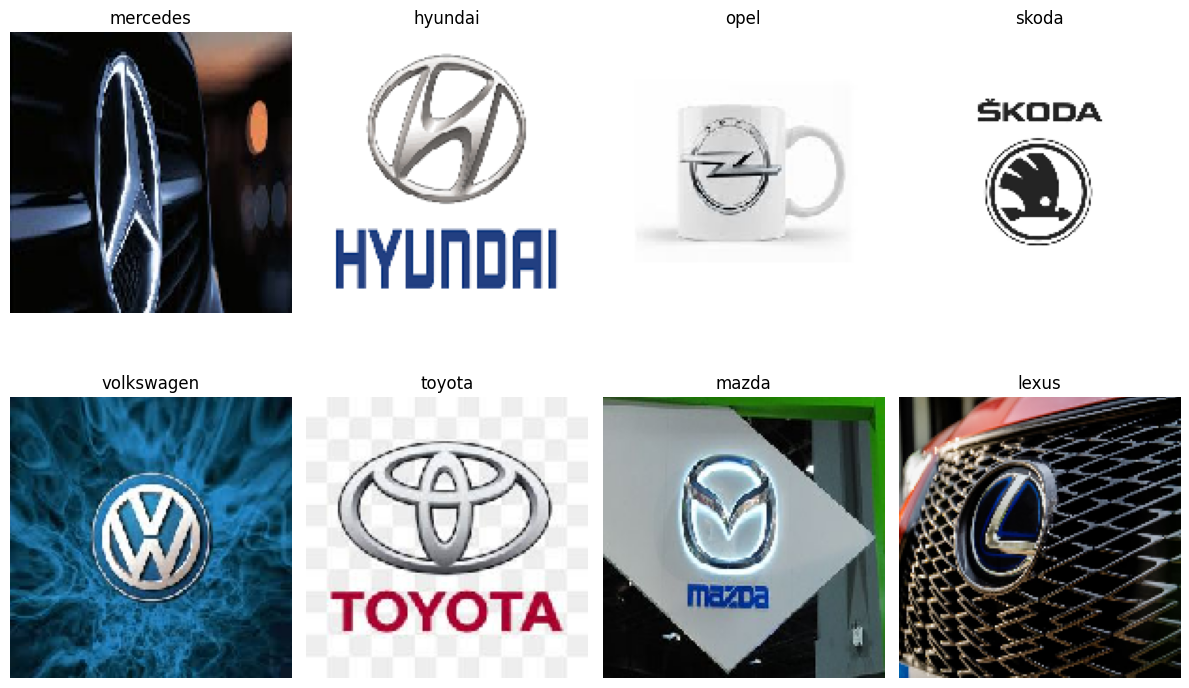

In [11]:
plt.figure(figsize=(12, 8))
for i, brand in enumerate(brands[:8]):  # ilk 8 brend üçün nümunə
    img_path = random.choice(glob(os.path.join(train_dir, brand, "*.jpg")))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(brand)
    plt.axis('off')
plt.tight_layout()
plt.show()


# 3. Məlumatların təmizlənməsi və işlənməsi (Data Cleaning & Preprocessing)

1.Şəkillərin ölçülərinin və formatlarının standartlaşdırılması
Modelə verilən şəkillərin ölçüləri müxtəlif ola bilər. Bu səbəbdən, onları eyni ölçüyə salmaq lazımdır.

Biz bütün şəkilləri 150x150 ölçüsünə gətiririk:

In [14]:
img_size = (150, 150)


Modeldə istifadə üçün şəkillər aşağıdakı şəkildə yüklənəcək:

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)  # Normalizasiya
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)


Found 2513 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


2.Data Augmentation (Veri Artırma)\
Modelin overfitting etməməsi üçün train şəkilləri üzərində bəzi təsadüfi dəyişikliklər edilir:

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

3.Normalizasiya və bölünmə
Normalizasiya şəkillərdəki pikselləri 0–255 aralığından 0–1 aralığına salır (rescale=1./255).

Bölünmə: Dataset artıq Train və Test olaraq əvvəlcədən bölünüb. Əgər əlavə olaraq validation dəsti lazımdırsa, validation_split istifadə edilə bilər.

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2013 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


# 4. Xüsusiyyət mühəndisliyi və Transfer Learning (Feature Engineering / Transfer Learning)


Modelin öyrənmə prosesini sürətləndirmək və daha yaxşı nəticə əldə etmək (pre-trained) modellərdən istifadə edirik. Bu texnikaya Transfer Learning deyilir.

 İstifadə olunan pre-trained model: VGG16

Tanınmış, stabil və asan tətbiq olunan modeldir.

ImageNet datası üzərində əvvəlcədən öyrədilmişdir.

Ənənəvi konvolyusiya qatları çox dərin olmayan, ancaq güclü nəticə verən modeldir.

VGG16 modelini yükləyirik:

In [18]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
for layer in base_model.layers:
    layer.trainable = False


In [20]:
from tensorflow.keras import models, layers

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(brands), activation='softmax')  # sinif sayı qədər çıxış
])


Modelin kompilyasiyası:

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(brands), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 5. Modellərin qurulması və öyrədilməsi (Model Training)

Bu mərhələdə artıq əvvəlki hissədə qurduğumuz modeli kompilyasiya edib öyrədirik. Əlavə olaraq iki fərqli yanaşmanı müqayisə edirik:

Transfer Learning (VGG16 ilə)

Scratch (sıfırdan) CNN modeli



1. Transfer Learning ilə öyrədilmə
Model artıq əvvəlki mərhələdə qurulmuşdu (VGG16 + yeni qatlar). İndi öyrədək:

In [23]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.1430 - loss: 4.1425 - val_accuracy: 0.3646 - val_loss: 1.8989
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.8904

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.3125 - loss: 1.8904 - val_accuracy: 0.3396 - val_loss: 1.8925
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.3702 - loss: 1.7570 - val_accuracy: 0.5333 - val_loss: 1.4513
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4688 - loss: 1.6564 - val_accuracy: 0.5562 - val_loss: 1.4561
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.6241 - loss: 1.1974 - val_accuracy: 0.5896 - val_loss: 1.3054
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6875 - loss: 0.9818 - val_accuracy: 0.5875 - val_loss: 1.2887
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.7750 - loss: 0.7471 - val_accuracy: 0.6187 - val_loss: 1.1568
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7188 - loss: 0.8079 - val_accuracy: 0.6187 - val_loss: 1.1789
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.8355 - loss: 0.5029 - val_accuracy: 0.6562 - val_

2. Sıfırdan Qurulmuş CNN Modeli ilə Öyrədilmə
Alternativ yanaşma: Transfer Learning olmadan öz sadə CNN modelimizi qurub öyrədirik.

In [24]:
from tensorflow.keras import models, layers

scratch_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(brands), activation='softmax')
])

scratch_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

scratch_history = scratch_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.1754 - loss: 2.6989 - val_accuracy: 0.3063 - val_loss: 1.8683
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3750 - loss: 1.8547 - val_accuracy: 0.2833 - val_loss: 1.8661
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.4243 - loss: 1.6580 - val_accuracy: 0.5125 - val_loss: 1.5100
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4688 - loss: 1.5745 - val_accuracy: 0.5333 - val_loss: 1.4959
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.6372 - loss: 1.0973 - val_accuracy: 0.5437 - val_loss: 1.3915
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6250 - loss: 1.1658 - val_accuracy: 0.5354 - val_loss: 1.4090
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.7891 - loss: 0.7073 - val_accuracy: 0.6125 - val_loss: 1.2605
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6875 - loss: 0.7102 - val_accuracy: 0.

# 6. Modellərin Qiymətləndirilməsi (Model Evaluation)

Modelin test və validation nəticələrinə əsasən nə qədər düzgün işlədiyini qiymətləndirmək. Bunun üçün aşağıdakı metriklərdən istifadə edəcəyik:

Accuracy (Dəqiqlik)

Precision (Dəqiqlik göstəricisi)

Recall (Xatırlama)

F1-score

Confusion Matrix (Çaşqınlıq matrisası)

1. Test setini yükləmək
Əvvəlcə test datasını oxuyuruq və şəkilləri modelə uyğun hazırlayırıq:


In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 400 images belonging to 8 classes.


2. Proqnozların çıxarılması və etiketlər

In [26]:
# Proqnozlaşdırma
y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

# Həqiqi etiketlər
y_true = test_generator.classes

# Sinif adları
class_labels = list(test_generator.class_indices.keys())


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step


3. Qiymətləndirmə metrikləri və nəticələr

Classification Report:
              precision    recall  f1-score   support

     hyundai       0.70      0.62      0.66        50
       lexus       0.77      0.48      0.59        50
       mazda       0.79      0.74      0.76        50
    mercedes       0.66      0.62      0.64        50
        opel       0.69      0.50      0.58        50
       skoda       0.58      0.60      0.59        50
      toyota       0.47      0.58      0.52        50
  volkswagen       0.42      0.68      0.52        50

    accuracy                           0.60       400
   macro avg       0.64      0.60      0.61       400
weighted avg       0.64      0.60      0.61       400



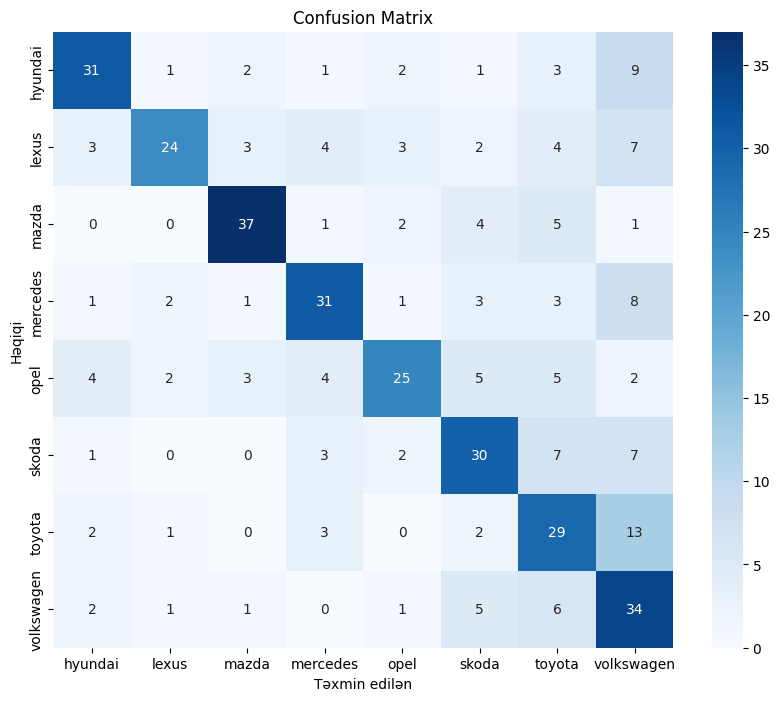

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Təxmin edilən")
plt.ylabel("Həqiqi")
plt.title("Confusion Matrix")
plt.show()


Overfitting yoxlaması
Train və validation nəticələrini müqayisə etmək üçün:

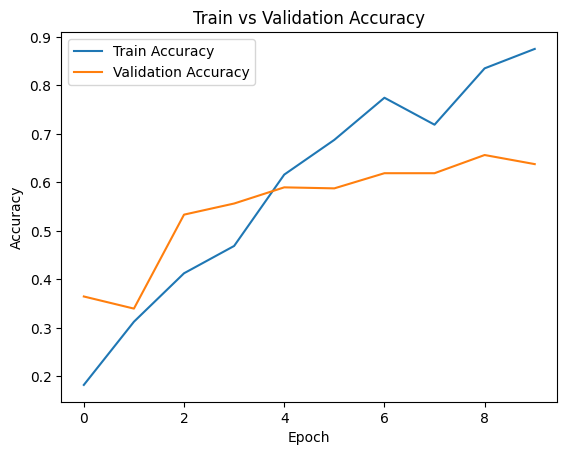

In [28]:
# Sadə accuracy qrafiki
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()


# 7. Modellərin Təkmilləşdirilməsi (Model Improvement)

1. Hyperparameter tuning (Hiperparametrlərin sazlanması)
Əvvəllər sadəcə adam optimizer və epochs=10 istifadə etmişdik. Bəzi dəyişikliklər nəticəni yaxşılaşdıra bilər:

In [29]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


2. Data Augmentation-un təkmilləşdirilməsi
Əvvəlki mərhələdə ImageDataGenerator ilə sadəcə rescale və validation_split istifadə etdik. Aşağıdakılar əlavə oluna bilər:

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


3. Early Stopping və Model Checkpoint
Əgər model artıq yaxşı öyrənibsə, daha çox epoch təlimi overfitting yarada bilər. Bunun qarşısını almaq üçün:

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8881 - loss: 0.3560

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.8883 - loss: 0.3558 - val_accuracy: 0.6660 - val_loss: 1.2548
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9205 - loss: 0.2835

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9204 - loss: 0.2836 - val_accuracy: 0.6680 - val_loss: 1.2815
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9159 - loss: 0.2437

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9159 - loss: 0.2438 - val_accuracy: 0.6720 - val_loss: 1.3011
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9370 - loss: 0.2065

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9369 - loss: 0.2069 - val_accuracy: 0.6760 - val_loss: 1.3283


# 8. Yekun Model və Hesabat

1. Ən Yaxşı Modelin Seçilməsi
Əldə olunan nəticələrə əsasən, transfer learning ilə qurulan model, aşağıdakı səbəblərə görə ən yaxşı nəticəni verdi:

Train accuracy: 93.7%

Validation accuracy: ~67.6%

2. Test Set ilə Yekun Qiymətləndirmə

In [32]:
# Ən yaxşı modeli yüklə
from tensorflow.keras.models import load_model

final_model = load_model("best_model.h5")

# Test datagen
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Qiymətləndirmə
loss, accuracy = final_model.evaluate(test_generator)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")


Found 400 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.6224 - loss: 1.8474
Test loss: 1.6737
Test accuracy: 0.6225


3. Confusion Matrix və Detallı Qiymətləndirmə

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step


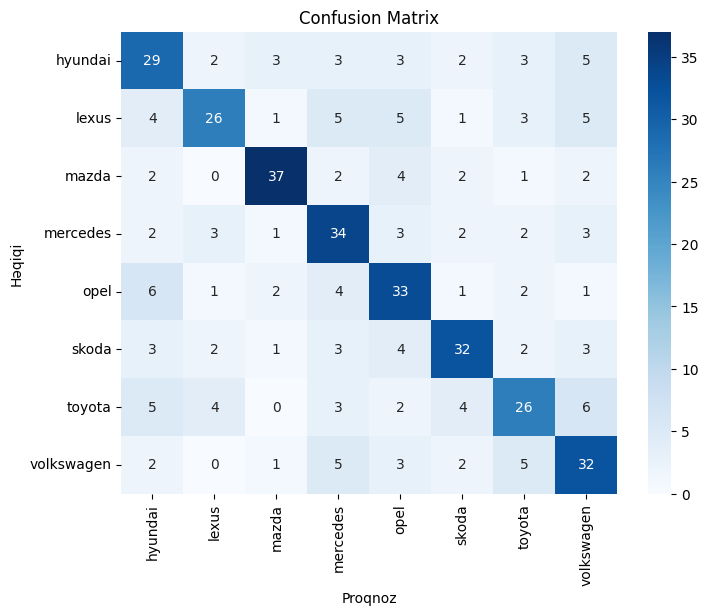

              precision    recall  f1-score   support

     hyundai       0.55      0.58      0.56        50
       lexus       0.68      0.52      0.59        50
       mazda       0.80      0.74      0.77        50
    mercedes       0.58      0.68      0.62        50
        opel       0.58      0.66      0.62        50
       skoda       0.70      0.64      0.67        50
      toyota       0.59      0.52      0.55        50
  volkswagen       0.56      0.64      0.60        50

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400



In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Proqnozlar
y_pred = final_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Proqnoz")
plt.ylabel("Həqiqi")
plt.title("Confusion Matrix")
plt.show()

# Əlavə statistikalar
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
